In [1]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# Data Preprocessing

In [6]:
def preprocess(data_file, calc_features=False, baseline=None):
    produce_spectra = pickle.load(open(data_file, "rb"), encoding='latin1')

    reflectances = np.array([item[:-1] for item in produce_spectra])
    labels = np.array([int(item[-1]) for item in produce_spectra])
    
    baseline = baseline

    if calc_features:
        feature_vectors = []
        for curve in reflectances:
            div = utils.spectral_info_divergence(baseline, curve)
            corr = utils.spectral_correlation(baseline, curve)
            dist = utils.euclidean_distance(baseline, curve)
            angle = utils.spectral_angle(baseline, curve)
            feature_vectors.append([div,corr,dist,angle])

        return {'feature': np.vstack(feature_vectors), "label": labels}
    else:
        return {'feature': np.vstack(reflectances), "label": labels}

In [8]:
data = preprocess("../Formatted_Data/banana.p")

In [9]:
labels = data["label"]
features = data["feature"]

In [10]:
def partition(data, labels, features):
    data_by_day = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: []}
    for i in range(len(labels)):
        if labels[i] < 8:
            data_by_day[labels[i]].append((features[i], labels[i]))
        
    return data_by_day

In [24]:
def get_batch(data, seq_length=1, batch_size=25):
    if seq_length == 1:
        # get data from day
        idx = np.random.choice(np.arange(7)+1, size=batch_size)
        
        # select a random sample from the day
        x_train = []
        y_train = []
        for i in idx:
            data_for_day = data[i]
            selection = random.choice(data_for_day)
            
            # append the features
            x_train.append(selection[0])
            
            # append the labels
            y_train.append(7 - selection[1]) # want days remaining to 7
            
        x_train = np.vstack(x_train).reshape(seq_length, batch_size, 290)
        y_train = np.array(y_train).reshape(len(y_train), 1)
            
        return (torch.FloatTensor(x_train), torch.FloatTensor(y_train))
    else:
        x_train = []
        y_train = []
        for i in range(batch_size):
            sequence = []
            label = 0
            
            # want to choose a random starting index that is 7 - seq_length max
            start = np.random.choice(np.arange(7 - seq_length)+1) # adding +1 so index starts at 1 not 0
            for j in range(start, start+seq_length):
                data_for_day = data[j]
                selection = random.choice(data_for_day)
                
                # append the features
                sequence.append(selection[0])
                
                # update the label (the final value will be retained)
                label = 7 - selection[1]
                
            x_train.append(sequence)
            y_train.append(label)
        
        x_train = np.reshape(x_train, (seq_length, batch_size, 290))
        y_train = np.array(y_train).reshape(len(y_train), 1)
        return (torch.FloatTensor(x_train), torch.FloatTensor(y_train))
                
                
                
                
    

# Define the network

In [12]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super (RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, bidirectional=False)
        self.linear = nn.Linear(hidden_size, 1)
        
    def forward(self, input, hidden=None):
        output = F.relu(input)
        output, hidden = self.lstm(output, hidden)
        output = self.linear(output[-1, :, :])
        return output

### test a batch

In [14]:
train_data = partition(data, labels, features)

In [31]:
sample = get_batch(train_data, seq_length=2)

In [32]:
print(sample[0].shape)

torch.Size([2, 25, 290])


In [28]:
ex_rnn = RNN(290, 100)

In [29]:
output = ex_rnn(sample[0])

In [30]:
print(output.size())

torch.Size([25, 1])


# Create training func

In [34]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [35]:
def train(data, net, optimizer, criterion, n_iters, print_every=1000):
    start = time.time()
    plot_losses = []
    seq_lengths = np.arange(6) + 1
    
    loss_total = 0
    for i in range(1, n_iters+1):
        sample, label = get_batch(data, seq_length=np.random.choice(seq_lengths))
        
        # zero parameter gradients
        optimizer.zero_grad()
        
        output = net(sample)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
        plot_losses.append(loss.item())
        
        if i % print_every == 0:
            loss_avg = loss_total / print_every
            loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, i / n_iters),
                                         i, i / n_iters * 100, loss_avg))
            
    return plot_losses

        

# Train network

In [93]:
net = RNN(290, 200)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.005)

In [94]:
loss_curve = train(train_data, net, optimizer, criterion, 20000)

0m 12s (- 3m 57s) (1000 5%) 1.4962
0m 25s (- 3m 51s) (2000 10%) 1.3357
0m 40s (- 3m 48s) (3000 15%) 1.2412
0m 55s (- 3m 43s) (4000 20%) 1.1558
1m 8s (- 3m 25s) (5000 25%) 1.1067
1m 21s (- 3m 10s) (6000 30%) 1.1892
1m 36s (- 2m 59s) (7000 35%) 1.1451
1m 48s (- 2m 43s) (8000 40%) 1.1269
2m 1s (- 2m 28s) (9000 45%) 1.0645
2m 13s (- 2m 13s) (10000 50%) 1.0558
2m 25s (- 1m 59s) (11000 55%) 1.0756
2m 37s (- 1m 45s) (12000 60%) 1.0259
2m 52s (- 1m 32s) (13000 65%) 0.9766
3m 5s (- 1m 19s) (14000 70%) 1.0305
3m 17s (- 1m 5s) (15000 75%) 0.9920
3m 29s (- 0m 52s) (16000 80%) 0.9935
3m 41s (- 0m 39s) (17000 85%) 0.9637
3m 53s (- 0m 25s) (18000 90%) 0.9772
4m 5s (- 0m 12s) (19000 95%) 1.0103
4m 17s (- 0m 0s) (20000 100%) 0.9704


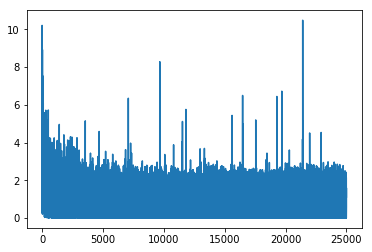

In [38]:
plt.plot(loss_curve)
plt.show()

# Evaluation

In [40]:
test_data = preprocess("../Formatted_Data/banana1_dr.p")

In [41]:
print(test_data["feature"].shape)

(50, 290)


In [90]:
sample = []
sample.append(test_data["feature"][2])
sample.append(test_data["feature"][11])
sample.append(test_data["feature"][22])
sample.append(test_data["feature"][32])
sample = np.vstack(sample)
print(sample.shape)

(4, 290)


In [91]:
sample = sample.reshape((4, 1, 290))
print(sample.shape)
sample = torch.FloatTensor(sample)
print(sample.size())

(4, 1, 290)
torch.Size([4, 1, 290])


In [92]:
with torch.no_grad():
    net.eval()
    out = net(sample)
    print(out)

tensor([[ 2.0616]])


In [45]:
print(test_data["label"])

[6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0]
